<a href="https://colab.research.google.com/github/yashpatel1994/efficient-algo-lab/blob/master/QSC_quantum_training_days_21_june_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the pre-requisite packages for doing classification using quantum machine learning (QML).

In [ ]:
!pip install tensorflow==2.15
!pip install tensorflow-quantum==0.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12.1
    Uninstalling sympy-1.12.1:
      Successfully uninstalled sympy-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; pla

In this Tutorial we will present an example of how a Parametrized Quantum Circuit (PQC) can be used to solve a supervised learning task in machine learning with classical data.

In supervised learning the goal is to learn a function that maps given inputs to their corresponding outputs (i.e., their labels), based on example input-output pairs (i.e., the training data).

A PQC can be used as a learning model in the following way: first input data is encoded in a quantum state through unitary operators, then variational parameters are added to the model using parametrized rotations.
![barren_2.png](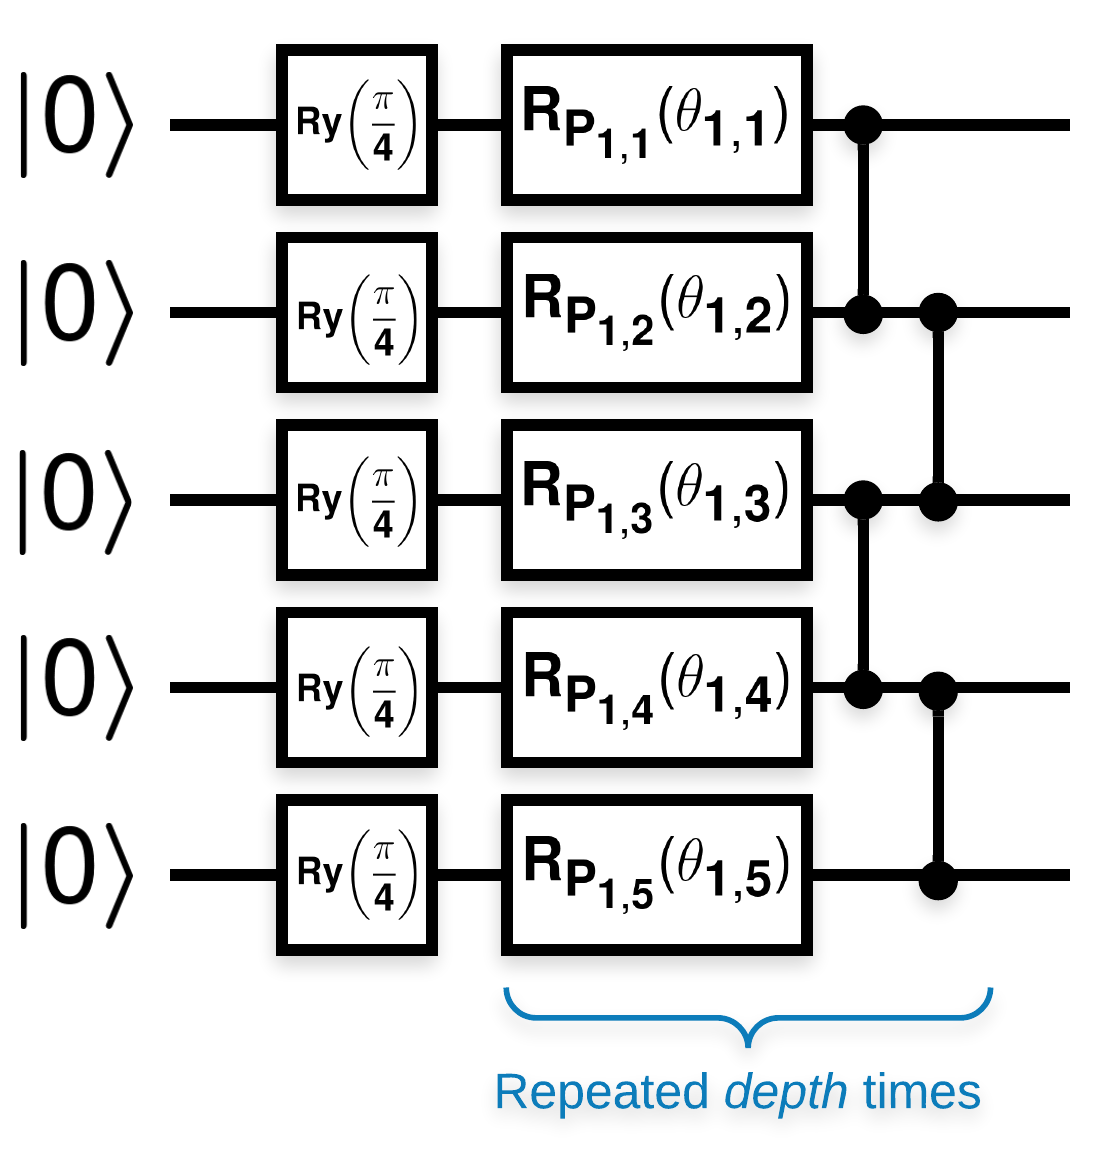![barren_2.png](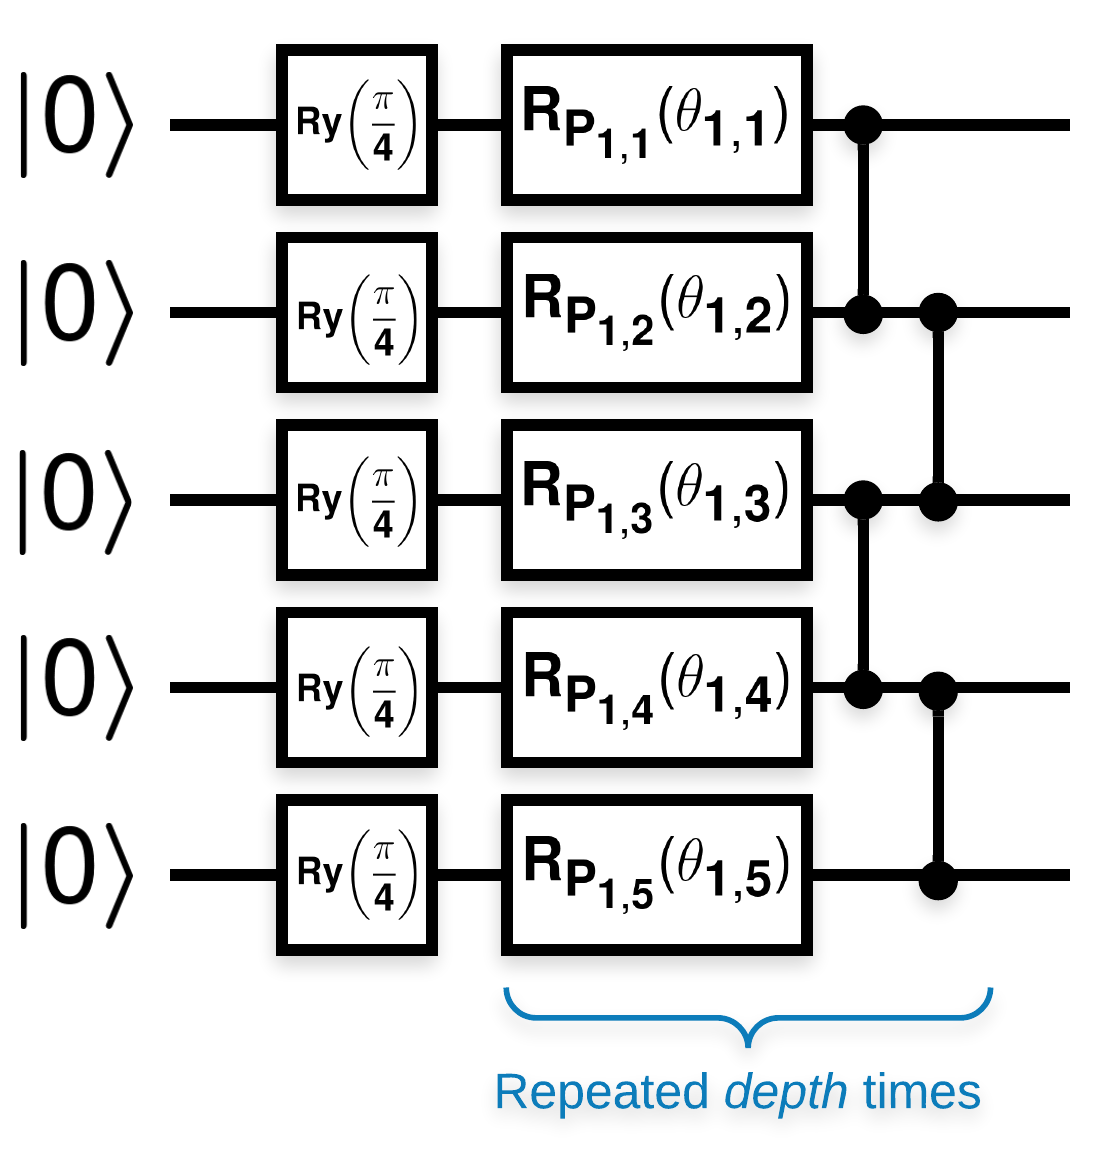![Screenshot 2024-06-20 at 13.34.50.png](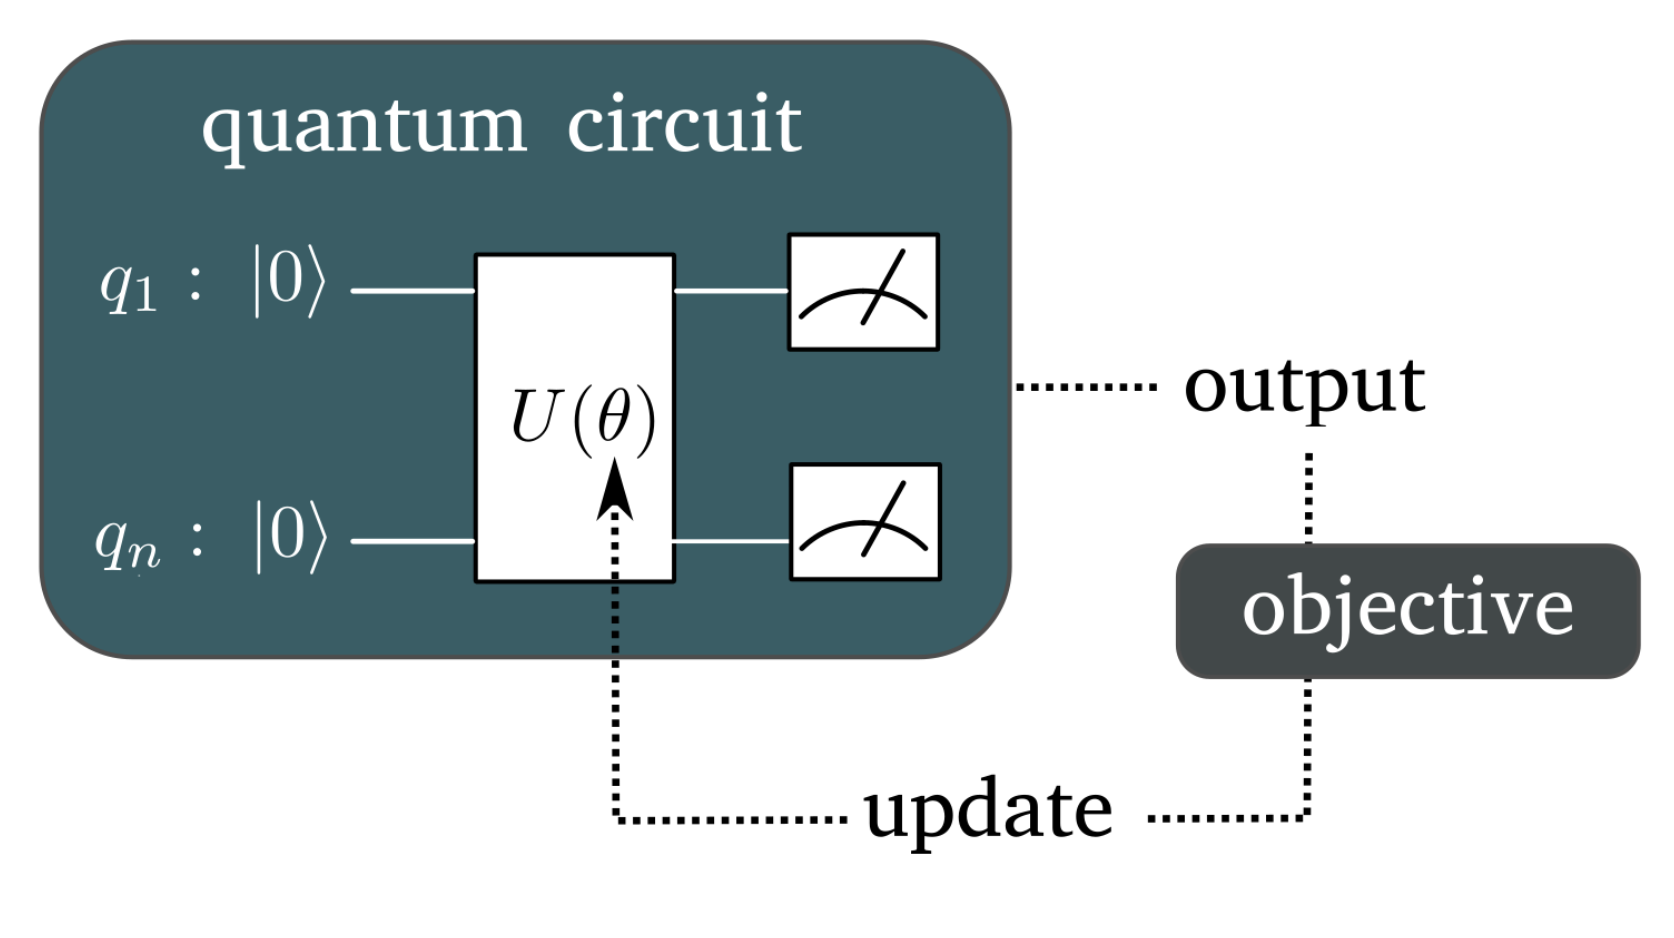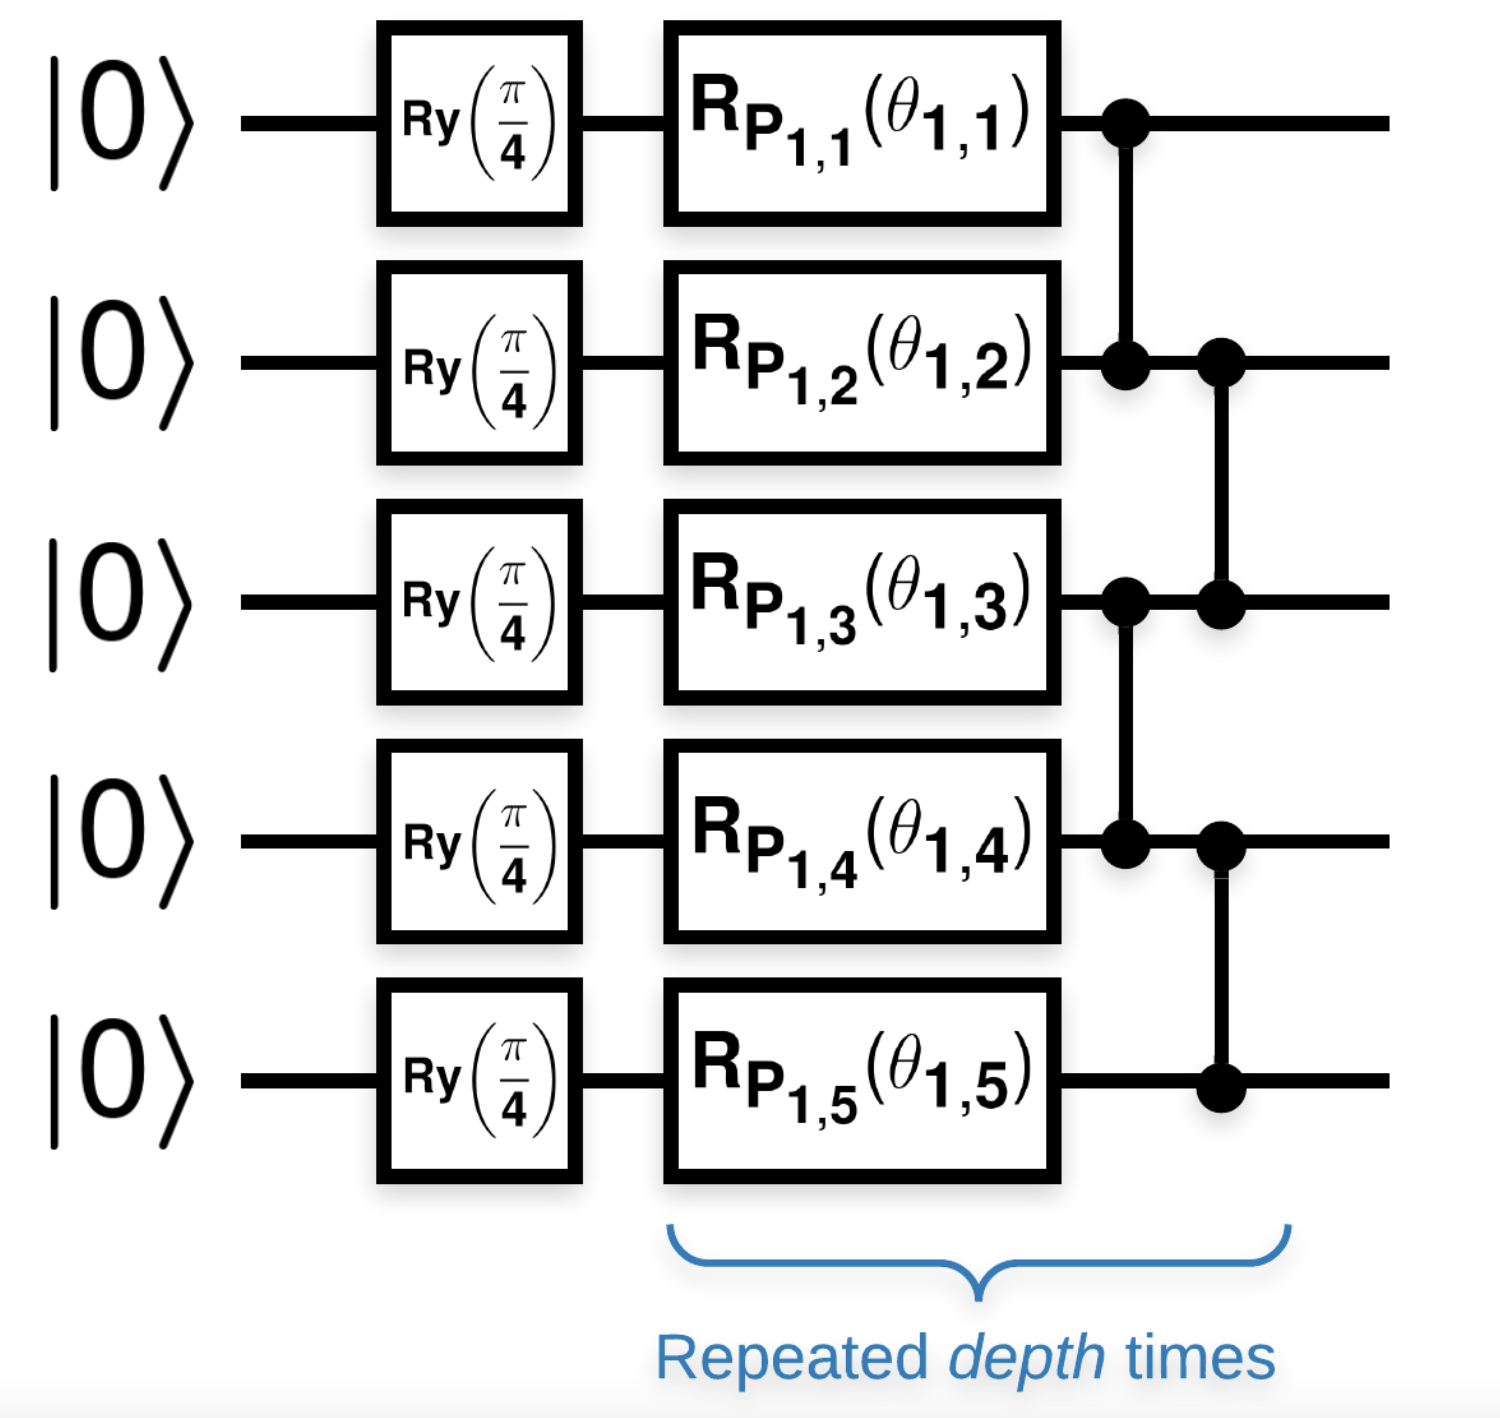)))
The label associated to a given input is given by taking the expectation value of an observable and classify the given input accordingly of its value. During the training, the variational parameters are updated by a classical optimizer comparing the labels given by the PQC with the true labels using an appropriate loss function.


The schematic workflow of the training process is represented in the figure below:


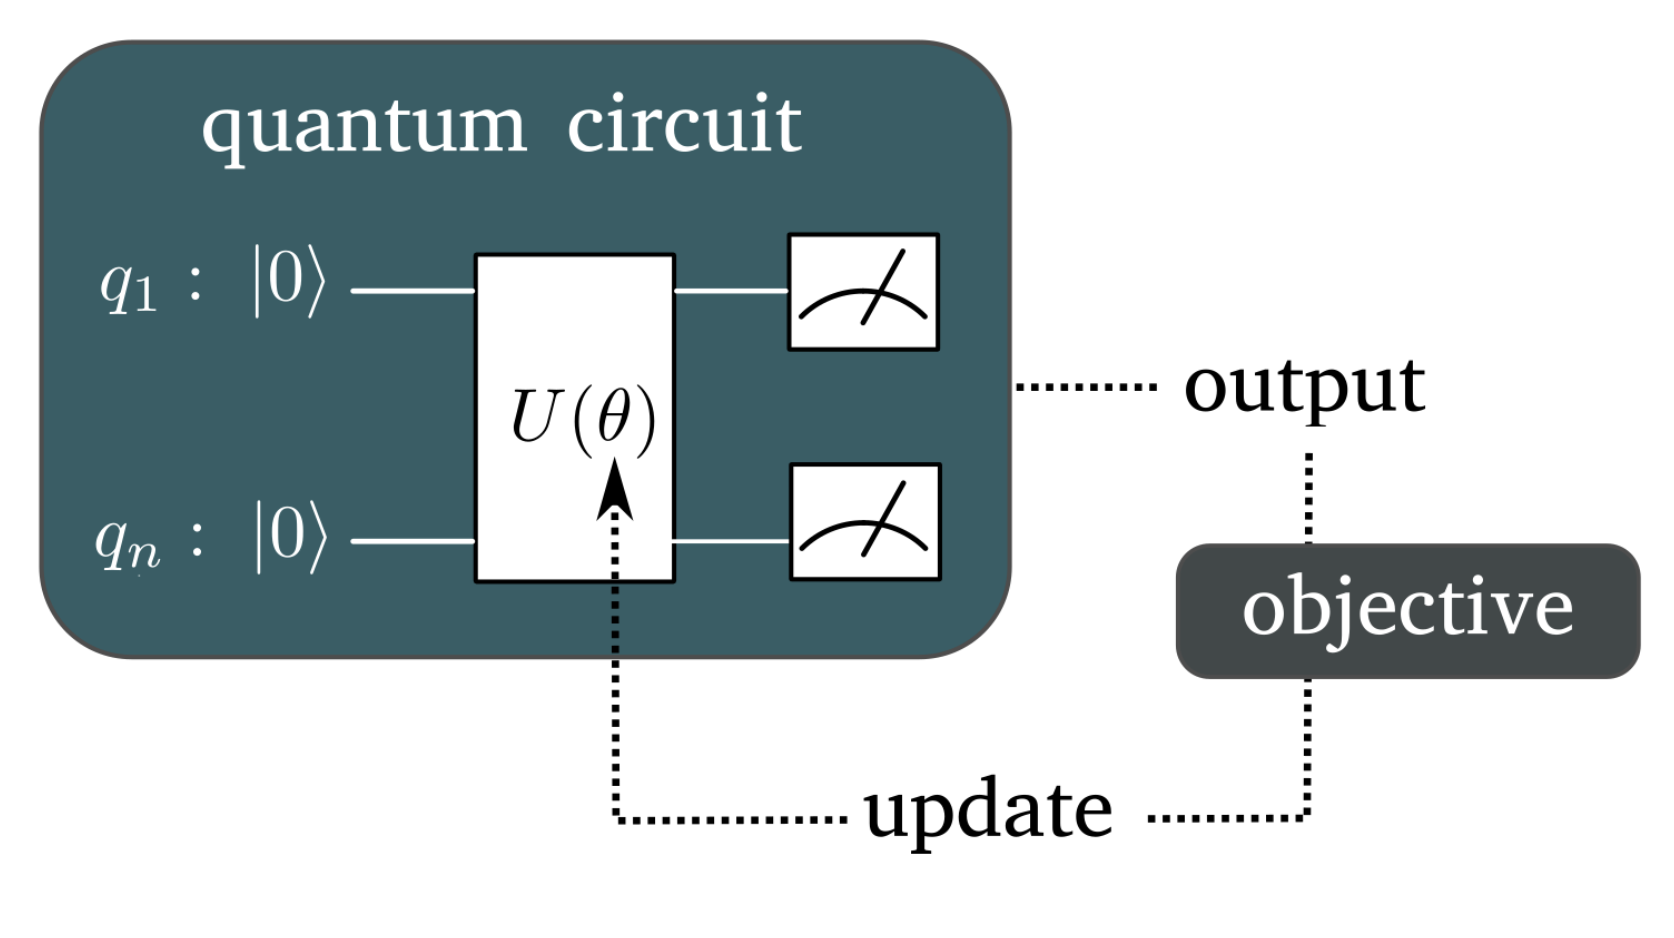

Necessary imports

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


np.random.seed(1234)

Here we load the dataset we are using in this tutorial, which is called Fashion-MNIST. In particular we will be classyfing trousers vs shirt images!

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

4422102/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the T-shirts/tops and trousers, remove the other classes. At the same time convert the label, y, to boolean: True for 0 and False for 1.

In [ ]:
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [ ]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12000
Number of filtered test examples: 2000


True


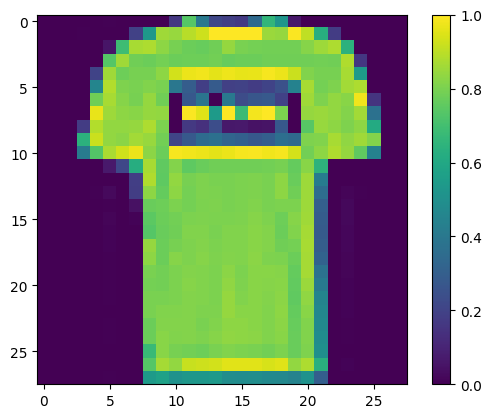

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()

False


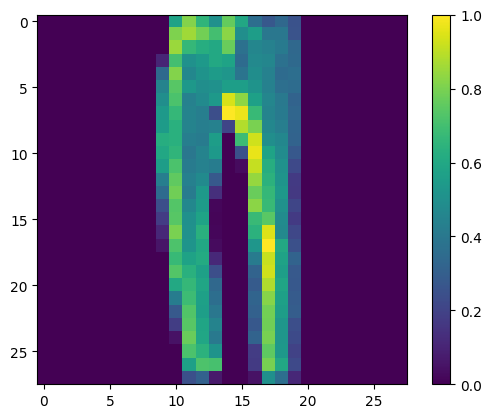

In [ ]:
print(y_train[100])

plt.imshow(x_train[100])
plt.colorbar()

We need to reduce the dimensionality of the pictures (i.e. number of pixels) down to a suitable number such that each input image can be encoded in a quantum circuit of *n* qubits.

In [ ]:
def apply_pca(X, n_components):
  """Applying a specific dimentionality reduction technique of Principal Component Analysis."""
  X_flat = np.array([x.flatten() for x in X])
  pca = PCA(n_components=n_components)
  X_pca = pca.fit_transform(X_flat)
  return X_pca

n_components = 6 # equivalent to number of qubits
x_train_pca = apply_pca(x_train, n_components)
x_test_pca = apply_pca(x_test, n_components)

Let's start constructing our circuit! First we build the essential gates for the variational part.

In [ ]:
def one_qubit_rotation(qubit, symbols):
  """
  Returns Cirq gates that apply a rotation of the bloch sphere about the Z,
  Y and Z axis, which is a universal rotation gate specified by the values in `symbols`.
  """
  return [cirq.rz(symbols[0])(qubit),
          cirq.ry(symbols[1])(qubit),
          cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
  """
  Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
  """
  cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
  cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
  return cz_ops

We are now ready to construct the whole circuit. First we will build a simple PQC with one encoding layer and multiple variational layers.

Later, you will be asked to construct a PQC with multiple re-uploading layers!

In [ ]:
def generate_circuit(qubits, n_layers):
  """Prepares a circuit where classical data is encoded on `qubits` with `n_layers` layers."""
  # Number of qubits
  n_qubits = len(qubits)

  # Sympy symbols for variational angles
  params = sympy.symbols(f'theta(0:{3*(n_layers + 1) * n_qubits})')
  params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

  # Sympy symbols for encoding angles
  inputs = sympy.symbols(f'x(0:{n_qubits})')
  inputs = np.asarray(inputs).reshape((n_qubits,))

  # Define circuit
  circuit = cirq.Circuit()
  # Encode the classical data in the quantum circuit
  circuit += cirq.Circuit(cirq.rx(inputs[i])(q) for i, q in enumerate(qubits))

  for l in range(n_layers):
    # Variational layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
    # Entangling layer
    circuit += entangling_layer(qubits)

  # Last varitional layer
  circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i, q in enumerate(qubits))

  return circuit, list(params.flat), list(inputs.flat)



def generate_data_reuploading_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers + 1) * n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))

    # Define circuit
    circuit = cirq.Circuit()
    #TODO: write the code which implements the data re-uploading circuit




    return circuit, list(params.flat), list(inputs.flat)

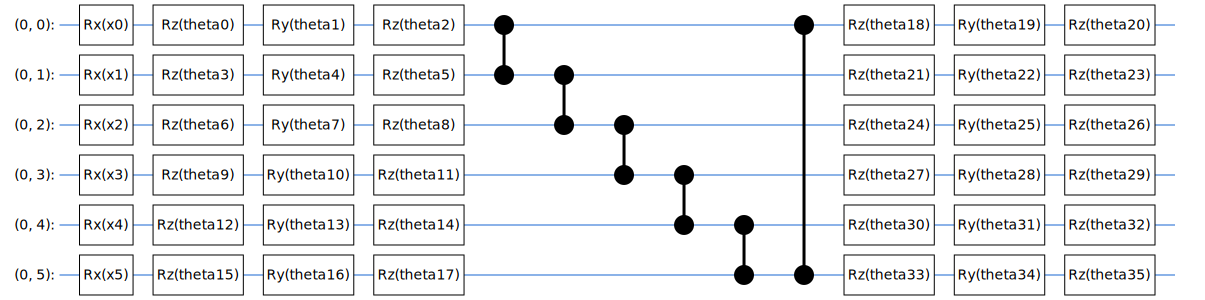

In [ ]:
n_qubits, n_layers = 6, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

Here we just define the classes of our two models (simple PQC and re-uploading model).

As exercise, you will have to change the initial distribution under which the variational parameters are initialized. This will show you how important it is the choice of the initial parametrization!

In [ ]:
class ClassifierPQC(tf.keras.layers.Layer):

  def __init__(self, qubits, n_layers, observables, trainable_encoding=False, activation="linear", name="classifier_PQC"):
    super(ClassifierPQC, self).__init__(name=name)
    self.n_layers = n_layers
    self.n_qubits = len(qubits)

    circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

    theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)

    #TODO: try to initialize the variational parameters using another distribution (e.g. Glorot initialization)

    self.theta = tf.Variable(
        initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
        trainable=True, name="thetas"
    )

    lmbd_init = tf.ones(shape=(self.n_qubits,))
    self.lmbd = tf.Variable(
        initial_value=lmbd_init, dtype="float32", trainable=trainable_encoding, name="lambdas"
    )

    # Define explicit symbol order.
    symbols = [str(symb) for symb in theta_symbols + input_symbols]
    self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

    self.activation = activation
    self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
    self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)

  def call(self, inputs):
    batch_dim = tf.gather(tf.shape(inputs[0]), 0)
    tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
    tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
    scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, inputs[0])
    squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

    joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
    joined_vars = tf.gather(joined_vars, self.indices, axis=1)

    return self.computation_layer([tiled_up_circuits, joined_vars])


class ClassifierReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, trainable_encoding=False, activation="linear", name="classifier_re-uploading_PQC"):
        super(ClassifierReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        #TODO: try to initialize the variational parameters using another distribution (e.g. Glorot initialization)

        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=trainable_encoding, name="lambdas"
        )

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])

Here we choose which observable we are going to measure. First we will be using a local observable, you will be asked later to try with a global one.

In [ ]:
n_qubits = 6 # Dimension of the PCA
n_layers = 5 # Number of layers in the PQC

qubits = cirq.GridQubit.rect(1, n_qubits)

local_observable = [cirq.Z(qubits[0])]

#TODO: Define a gobal observable.




In [ ]:
def generate_classifier(qubits, n_layers, observables, trainable_encoding=False, activation='linear', name='classifier-PQC'):
  """Generates a Keras model for a PQC classifier."""

  input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
  pqc = ClassifierPQC(qubits, n_layers, observables, trainable_encoding, activation, name)([input_tensor])
  model = tf.keras.Model(inputs=[input_tensor], outputs=pqc)

  return model

def generate_data_reuploading_classifier(qubits, n_layers, observables, trainable_encoding=False, activation='linear', name='classifier_re-uploading_PQC'):
  """Generates a Keras model for a PQC classifier."""

  input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
  pqc = ClassifierReUploadingPQC(qubits, n_layers, observables, trainable_encoding, activation, name)([input_tensor])
  model = tf.keras.Model(inputs=[input_tensor], outputs=pqc)

  return model

vanilla_model = generate_classifier(qubits, n_layers, local_observable)
trainable_input_model = generate_classifier(qubits, n_layers, local_observable, trainable_encoding=True, activation='linear', name='trainable_input_classifier-PQC')

vanilla_data_reuploading_model = generate_data_reuploading_classifier(qubits, n_layers, local_observable)
trainable_input_data_reuploading_model = generate_data_reuploading_classifier(qubits, n_layers, local_observable, trainable_encoding=True, activation='linear', name='trainable_input_classifier_re-uploading_PQC')

vanilla_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

# trainable_input_model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     optimizer=tf.keras.optimizers.Adam(0.01),
#     metrics=[tf.keras.metrics.BinaryAccuracy()],
# )

vanilla_data_reuploading_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

# trainable_input_data_reuploading_model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     optimizer=tf.keras.optimizers.Adam(0.01),
#     metrics=[tf.keras.metrics.BinaryAccuracy()],
# )

print(vanilla_model.summary())
print()
print()
print("------------------------------------------------------------------")
print()
print()
# print(trainable_input_model.summary())
# print("------------------------------------------------------------------")
# print()
# print()
print(vanilla_data_reuploading_model.summary())
# print("------------------------------------------------------------------")
# print()
# print()
# print(trainable_input_data_reuploading_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6)]               0         
                                                                 
 classifier-PQC (Classifier  (None, 1)                 114       
 PQC)                                                            
                                                                 
Total params: 114 (456.00 Byte)
Trainable params: 108 (432.00 Byte)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________
None


------------------------------------------------------------------


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6)]               0         
                                                             

Let's try our models and see the performances!

In [ ]:
vanilla_model.fit(x_train_pca, y_train, batch_size=32, epochs=10, validation_split=0.8)

Epoch 1/10
75/75 [==============================] - 58s 768ms/step - loss: 2.5615 - binary_accuracy: 0.5190 - val_loss: 1.0646 - val_binary_accuracy: 0.4912
Epoch 2/10
75/75 [==============================] - 56s 757ms/step - loss: 0.8239 - binary_accuracy: 0.6023 - val_loss: 0.6399 - val_binary_accuracy: 0.6920
Epoch 3/10
75/75 [==============================] - 57s 762ms/step - loss: 0.6653 - binary_accuracy: 0.7140 - val_loss: 0.6540 - val_binary_accuracy: 0.6653
Epoch 4/10
75/75 [==============================] - 57s 761ms/step - loss: 0.5776 - binary_accuracy: 0.7407 - val_loss: 0.4934 - val_binary_accuracy: 0.7773
Epoch 5/10
75/75 [==============================] - 57s 765ms/step - loss: 0.4903 - binary_accuracy: 0.8008 - val_loss: 0.4381 - val_binary_accuracy: 0.8153
Epoch 6/10
75/75 [==============================] - 57s 765ms/step - loss: 0.4403 - binary_accuracy: 0.8274 - val_loss: 0.4012 - val_binary_accuracy: 0.8294
Epoch 7/10
75/75 [==============================] - 59s 79

In [ ]:
#vanilla_data_reuploading_model.fit(x_train_pca, y_train, batch_size=32, epochs=50, validation_split=0.8)

Epoch 1/50
75/75 [==============================] - 39s 505ms/step - loss: 1.8645 - binary_accuracy: 0.5419 - val_loss: 0.8232 - val_binary_accuracy: 0.5616
Epoch 2/50
75/75 [==============================] - 52s 704ms/step - loss: 0.7049 - binary_accuracy: 0.6382 - val_loss: 0.6677 - val_binary_accuracy: 0.6868
Epoch 3/50
75/75 [==============================] - 52s 701ms/step - loss: 0.5895 - binary_accuracy: 0.7207 - val_loss: 0.6050 - val_binary_accuracy: 0.7326
Epoch 4/50
75/75 [==============================] - 52s 706ms/step - loss: 0.5465 - binary_accuracy: 0.7391 - val_loss: 0.5785 - val_binary_accuracy: 0.7463
Epoch 5/50
75/75 [==============================] - 35s 471ms/step - loss: 0.5288 - binary_accuracy: 0.7436 - val_loss: 0.5834 - val_binary_accuracy: 0.7392
Epoch 6/50
75/75 [==============================] - 52s 705ms/step - loss: 0.5275 - binary_accuracy: 0.7445 - val_loss: 0.5552 - val_binary_accuracy: 0.7518
Epoch 7/50
75/75 [==============================] - 52s 69

#**Barren plateaus**

This part of the tutorial is taken from the TFQ Barren Plateaus Tutorial.

One of the major problem affecting the performance of PQCs consists in the fact that the gredients for a large family of random quantum circuits vanish almost everywhere. This represents a problem as the learning model will not be able to reach the optimial minimum but it will instead be stucked in a flat landscape. This phenomenon is called Barren plateaus.

In this part of the tutorial we will investigate this phenomenon by looking at the gradient of random circuits with respect to one "free" paramenter.

First, we will generate random PQC with random Pauli rotations for the variational layer.

The circuits will have the following form:



In [ ]:
def generate_random_qnn(qubits, symbol, depth):
    """Generate random QNN's with the same structure from McClean et al."""
    circuit = cirq.Circuit()
    for qubit in qubits:
        circuit += cirq.ry(np.pi / 4.0)(qubit)

    for d in range(depth):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            random_n = np.random.uniform()
            random_rot = np.random.uniform(
            ) * 2.0 * np.pi if i != 0 or d != 0 else symbol
            if random_n > 2. / 3.:
                # Add a Z.
                circuit += cirq.rz(random_rot)(qubit)
            elif random_n > 1. / 3.:
                # Add a Y.
                circuit += cirq.ry(random_rot)(qubit)
            else:
                # Add a X.
                circuit += cirq.rx(random_rot)(qubit)

        # Add CZ ladder.
        for src, dest in zip(qubits, qubits[1:]):
            circuit += cirq.CZ(src, dest)

    return circuit


generate_random_qnn(cirq.GridQubit.rect(1, 3), sympy.Symbol('theta'), 2)

(0, 0): ───Ry(0.25π)───Ry(theta)────@───Rx(1.9π)───────────────@───────
                                    │                          │
(0, 1): ───Ry(0.25π)───Ry(1.88π)────@───@──────────Rz(1.37π)───@───@───
                                        │                          │
(0, 2): ───Ry(0.25π)───Ry(0.794π)───────@──────────Rx(1.73π)───────@───

In [ ]:
This function computes the variance of the gradient of a given observable over a batch of circuits. We will use it to show that the variance goes to zero increasing the number of qubits

In [ ]:
def process_batch(circuits, symbol, op):
    """Compute the variance of a batch of expectations w.r.t. op on each circuit that
    contains `symbol`. Note that this method sets up a new compute graph every time it is
    called so it isn't as performant as possible."""

    # Setup a simple layer to batch compute the expectation gradients.
    expectation = tfq.layers.Expectation()

    # Prep the inputs as tensors
    circuit_tensor = tfq.convert_to_tensor(circuits)
    values_tensor = tf.convert_to_tensor(
        np.random.uniform(0, 2 * np.pi, (n_circuits, 1)).astype(np.float32))

    # Use TensorFlow GradientTape to track gradients.
    with tf.GradientTape() as g:
        g.watch(values_tensor)
        forward = expectation(circuit_tensor,
                              operators=op,
                              symbol_names=[symbol],
                              symbol_values=values_tensor)

    # Return variance of gradients across all circuits.
    grads = g.gradient(forward, values_tensor)
    grad_var = tf.math.reduce_std(grads, axis=0)
    return grad_var.numpy()[0]

We are now ready to lunch our experiment!

We generate random PQCs of the structure above where we measure a local ZZ observable. We compute the gradient with respect to the one free variational parameter in the circuit and we monitor the average of its variance as the number of qubits increases

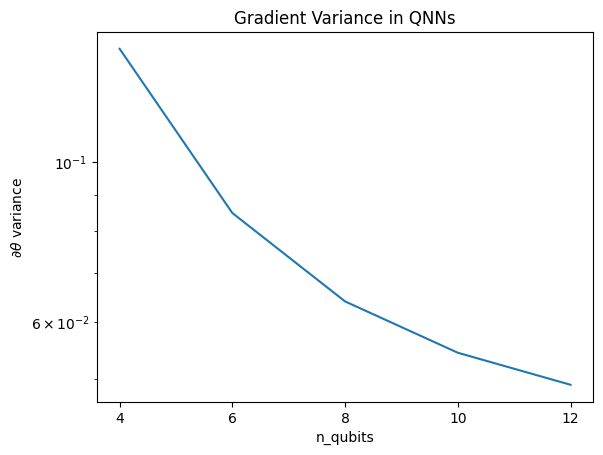

In [ ]:
n_qubits = [2 * i for i in range(2, 7)
           ]  # Ranges studied in paper are between 2 and 24.
depth = 50  # Ranges studied in paper are between 50 and 500.
n_circuits = 200
theta_var = []

for n in n_qubits:
    # Generate the random circuits and observable for the given n.
    qubits = cirq.GridQubit.rect(1, n)
    symbol = sympy.Symbol('theta')
    circuits = [
        generate_random_qnn(qubits, symbol, depth) for _ in range(n_circuits)
    ]
    op = cirq.Z(qubits[0]) * cirq.Z(qubits[1])
    theta_var.append(process_batch(circuits, symbol, op))

plt.semilogy(n_qubits, theta_var)
plt.title('Gradient Variance in QNNs')
plt.xlabel('n_qubits')
plt.xticks(n_qubits)
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

An heuristic initialitation procedure to face the problem, based on https://arxiv.org/pdf/1903.05076

In [ ]:
def generate_identity_qnn(qubits, symbol, block_depth, total_depth):
    """Generate random QNN's with the same structure from Grant et al."""
    circuit = cirq.Circuit()

    # Generate initial block with symbol.
    prep_and_U = generate_random_qnn(qubits, symbol, block_depth)
    circuit += prep_and_U

    # Generate dagger of initial block without symbol.
    U_dagger = (prep_and_U[1:])**-1
    circuit += cirq.resolve_parameters(
        U_dagger, param_resolver={symbol: np.random.uniform() * 2 * np.pi})

    for d in range(total_depth - 1):
        # Get a random QNN.
        prep_and_U_circuit = generate_random_qnn(
            qubits,
            np.random.uniform() * 2 * np.pi, block_depth)

        # Remove the state-prep component
        U_circuit = prep_and_U_circuit[1:]

        # Add U
        circuit += U_circuit

        # Add U^dagger
        circuit += U_circuit**-1

    return circuit


generate_identity_qnn(cirq.GridQubit.rect(1, 3), sympy.Symbol('theta'), 2, 2)

In [ ]:
block_depth = 10
total_depth = 5

heuristic_theta_var = []

for n in n_qubits:
    # Generate the identity block circuits and observable for the given n.
    qubits = cirq.GridQubit.rect(1, n)
    symbol = sympy.Symbol('theta')
    circuits = [
        generate_identity_qnn(qubits, symbol, block_depth, total_depth)
        for _ in range(n_circuits)
    ]
    op = cirq.Z(qubits[0]) * cirq.Z(qubits[1])
    heuristic_theta_var.append(process_batch(circuits, symbol, op))

plt.semilogy(n_qubits, theta_var)
plt.semilogy(n_qubits, heuristic_theta_var)
plt.title('Heuristic vs. Random')
plt.xlabel('n_qubits')
plt.xticks(n_qubits)
plt.ylabel('$\\partial \\theta$ variance')
plt.show()